# Time Series Analysis - BackTesting of Trend Trading

## This testing is to backtest trend trading strategy for SP500 stocks with huge market cap.
## The trading strategy using here is is based on the principles of trend following and momentum trading.
## Nvidia is selected for further analysis.
It operates on the assumption that price movements tend to persist in a given direction for a specific period before potentially reversing. The strategy buys when the stock price has been decreasing for a set number of consecutive days, anticipating a potential upward reversal. Conversely, it sells when the price has been increasing for a specified number of days, expecting a possible downward correction.

Backtesting is a concept often used in time series analysis, especially in finance. It's about evaluating a trading strategy by testing it on historical data to see how well it would have performed in the past. The goal is to determine whether the strategy would have yielded positive outcomes and if it's better than other strategies. The main goal here is testing a model or strategy by applying it to known historical data to evaluate its effectiveness.


In [50]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
symbols = sp500['Symbol'].tolist()

stocks_above_cap = []
min_market_cap = 1000000000000
for symbol in symbols:
    try:
        ticker = yf.Ticker(symbol)
        market_cap = ticker.info.get('marketCap', 0)
        
        if market_cap > min_market_cap:
            stocks_above_cap.append({
                'Symbol': symbol,
                'Company': ticker.info.get('longName', 'N/A'),
                'Market Cap': market_cap
            })
    except Exception as e:
        print(f"Error processing market cap for {symbol}: {str(e)}")
market_cap_df = pd.DataFrame(stocks_above_cap)

In [3]:
symbols = market_cap_df['Symbol']

market_cap_df

,Symbol,Company,Market Cap
0,GOOGL,Alphabet Inc.,1998459109376
1,GOOG,Alphabet Inc.,2000069984256
2,AMZN,"Amazon.com, Inc.",2034886901760
3,AAPL,Apple Inc.,3443272450048
4,META,"Meta Platforms, Inc.",1427855638528
5,MSFT,Microsoft Corporation,3222297116672
6,NVDA,NVIDIA Corporation,2851857760256


## Driver Function

In [51]:
def date_to_str(d):
    return f'{d.year}-{d.month}-{d.day}'

In [52]:
#get the historical prices for a stock
def get_ticker_data(symbol, start=None, end=None):
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(start=start, end=end, interval='1d').Close
        hist = hist[~hist.isna()]
        
        #day-to-day price difference
        diffs = hist.diff()
        hist = hist.reset_index()
        hist['price_change'] = diffs.values
        
        #cast datetime to date
        hist.Date = hist.Date.apply(lambda d: d.date())
    except:
        return None
    return hist.dropna()

In [53]:
class Strategy:
    def __init__(self, buy_condition: tuple, sell_condition: tuple):
        #check that both args are size 2 tuples
        if type(buy_condition) != tuple or len(buy_condition) != 2 or type(sell_condition) != tuple or len(sell_condition) != 2:
            raise Exception('buy_condition and sell_condition should each be size 2 tuples')
        buy_dir, buy_periods = buy_condition
        sell_dir, sell_periods = sell_condition
        
        #check that the buy and sell condition are increase or decrease
        if buy_dir not in ['decrease', 'increase'] or sell_dir not in ['decrease', 'increase']:
            raise Exception('first element of each tuple needs to be one of ["decrease", "increase"]')
            
        #check that the buy or sell periods are positve integers
        if type(buy_periods) != int or buy_periods <= 0 or type(sell_periods) != int or sell_periods <= 0:
            raise TypeError('second element of each tuple needs to be a positive integer')
            
        #set variables
        self.buy_dir = buy_dir
        self.buy_periods = buy_periods
        self.sell_dir = sell_dir
        self.sell_periods = sell_periods

In [54]:
def execute_strategy(history, strategy, debug=False):
    #start with $100 and no shares, remember inital value
    curr_value = 100
    initial_value = curr_value
    n_shares = 0
    
    #whether or not we're currently holding shares of the stock
    currently_holding = False
    
    #number of periods price has decreased or increased
    n_periods_dec = 0
    n_periods_inc = 0
    trade_count=0
    #backtest our strategy day-by-day
    for i,row in history.iterrows():
        
        #update periods of consecutive increasing or decreasing price
        if row.price_change < 0:
            n_periods_dec += 1
            n_periods_inc = 0
        elif row.price_change > 0:
            n_periods_inc += 1
            n_periods_dec = 0
        
        #try to buy only if we aren't currently holding shares
        if currently_holding == False:
            #buy only if the strategy's buy condition is met
            if (strategy.buy_dir == 'decrease' and n_periods_dec == strategy.buy_periods) or (strategy.buy_dir == 'increase' and n_periods_inc == strategy.buy_periods):
                #calulate number of shares we can buy 
                n_shares = curr_value / row.Close
                if debug:
                    print(f'bought {round(n_shares,2)} shares for ${round(row.Close, 2)} each on {row.Date}\n')
                #we now have no money and are holding shares, and reset periods of increasing or decreasing
                curr_value = 0
                n_periods_dec = 0
                n_periods_inc = 0
                currently_holding = True
                trade_count += 1
        
                
        #try to sell only if we are currently holding shares
        if currently_holding == True:
            #sell only if the strategy's sell condition is met
            if (strategy.sell_dir == 'decrease' and n_periods_dec == strategy.sell_periods) or (strategy.sell_dir == 'increase' and n_periods_inc == strategy.sell_periods):
                #get value of shares now
                curr_value = row.Close * n_shares
                if debug:
                    print(f'sold {round(n_shares,2)} shares for ${round(row.Close, 2)} each on {row.Date}\n')
                #we now own no shares, and reset periods of increasing or decreasing
                n_shares = 0
                n_periods_dec = 0
                n_periods_inc = 0
                currently_holding = False
                trade_count += 1
                
    #the final value is the max of money we have on hand and the money tied up in shares we currently own
    final_val = max(curr_value, row.Close*n_shares)
    
    #return the percent change from initial value
    return 100*(final_val / initial_value - 1), trade_count

## Create Strategy

In [55]:
buy_dec2_sell_inc2 = Strategy(
    buy_condition=('decrease', 2),
    sell_condition=('increase', 2)
)

In [56]:
buy_dec5_sell_inc5 = Strategy(
    buy_condition=('decrease', 5),
    sell_condition=('increase', 5)
)

In [57]:
strategies = {
    'buy_dec2_sell_inc2': buy_dec2_sell_inc2,
    'buy_dec5_sell_inc5': buy_dec5_sell_inc5
}

## BackTest

## Visualize Results

In [58]:
#generate all dates of 2022 to today
#all_dates = [date(2022,1,1) + timedelta(i) for i in range(365)]
all_dates = [date(2022,1,1) + timedelta(i) for i in range((date.today()-date(2022,1,1)).days+1)]

In [59]:
def run_backtest(symbols):
    #store the results of different strategies here
    all_results = {}
    all_history=[]
    for symbol in symbols:
        results = {k: [] for k in strategies.keys()}

        history = get_ticker_data(symbol, start=date_to_str(all_dates[0]), end=date_to_str(all_dates[-1]))
        all_history.append([symbol, history])
        #execute several simulations, each from a different starting date
    
        for start_date in all_dates[:-time_range]:
            #get the end date which is time_range days later
            end_date = start_date + timedelta(days=time_range)
            
            #get the price history between this start and end date
            history_lim = history[(history.Date >= start_date) & (history.Date <= end_date)]
            
            start_date = date_to_str(start_date)
            end_date = date_to_str(end_date)
            #execute each strategy on this historical data
            for name, strategy in strategies.items():
                result= execute_strategy(history_lim, strategy, debug=False)
                results[name].append([start_date,end_date,result])
        all_results[symbol]= results
        
    return all_results, all_history

## Plot Results

In [60]:
def plot(all_results,symbols):
    colors = ['r', 'b', 'g', 'k', 'orange', 'pink', 'gray', 'purple']
    num_symbols = len(symbols)
    fig, axes = plt.subplots(num_symbols, 1, figsize=(14, 5*num_symbols), squeeze=False)
    
    for sym_idx, symbol in enumerate(symbols):
        results = all_results[symbol]
        legend = []
        min_return = float('inf')
        max_return = float('-inf')
        max_y = float('-inf')
        
        conclusion = f'ticker = {symbol}\nNo strategy is expected to give positive return'
        best_avg_return = 0
        
        ax = axes[sym_idx, 0]
        for idx, (name, result) in enumerate(results.items()):
            returns = [x[2][0] for x in result]
            # colors[idx % len(colors)]: This sets the line width of the KDE curve to 2, making it a bit thicker and easier to see.
            distr_plot = sns.histplot(returns, kde=True, line_kws={'linewidth': 2}, 
                                      color=colors[idx % len(colors)], stat='probability', 
                                      bins=20, ax=ax)
            max_y = max(max_y, distr_plot.get_ylim()[1])
            legend.append(name)
            min_return = min(min_return, np.min(returns))
            max_return = max(max_return, np.max(returns))
            avg_return = np.mean(returns)
            if avg_return > best_avg_return:
                conclusion = f'ticker = {symbol}\n{name} gives the best average return ({round(avg_return,2)}%)'
                best_avg_return = avg_return
            print(f'{symbol} {name} gives the average return a {round(avg_return,2)}%')
            
    
        ax.legend(legend, fontsize=12)
        
        ax.set_title(conclusion, fontsize=16)
        ax.fill_betweenx([0,1], -100, 0, color='r', alpha=0.1)
        ax.fill_betweenx([0,1], 0, 100, color='g', alpha=0.1)
        ax.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.5)
        
        for idx, (name, result) in enumerate(results.items()):
            returns = [x[2][0] for x in result] 
            ax.axvline(np.mean(returns), color=colors[idx % len(colors)], linestyle='--', linewidth=2)
        
        ax.set_xlim(min_return, max_return)
        ax.set_ylim(0, max_y)
        
        ax.set_xlabel('Return (%)', fontsize=14)
        ax.set_ylabel('Probability', fontsize=14)
    
    plt.tight_layout()
    plt.show()

GOOGL buy_dec2_sell_inc2 gives the average return a 0.59%
GOOGL buy_dec5_sell_inc5 gives the average return a -0.14%
GOOG buy_dec2_sell_inc2 gives the average return a 0.69%
GOOG buy_dec5_sell_inc5 gives the average return a -0.14%
AMZN buy_dec2_sell_inc2 gives the average return a 1.08%
AMZN buy_dec5_sell_inc5 gives the average return a -0.21%
AAPL buy_dec2_sell_inc2 gives the average return a 1.09%
AAPL buy_dec5_sell_inc5 gives the average return a 0.47%
META buy_dec2_sell_inc2 gives the average return a 3.16%
META buy_dec5_sell_inc5 gives the average return a 0.28%
MSFT buy_dec2_sell_inc2 gives the average return a 2.11%
MSFT buy_dec5_sell_inc5 gives the average return a -0.04%
NVDA buy_dec2_sell_inc2 gives the average return a 3.95%
NVDA buy_dec5_sell_inc5 gives the average return a -0.04%


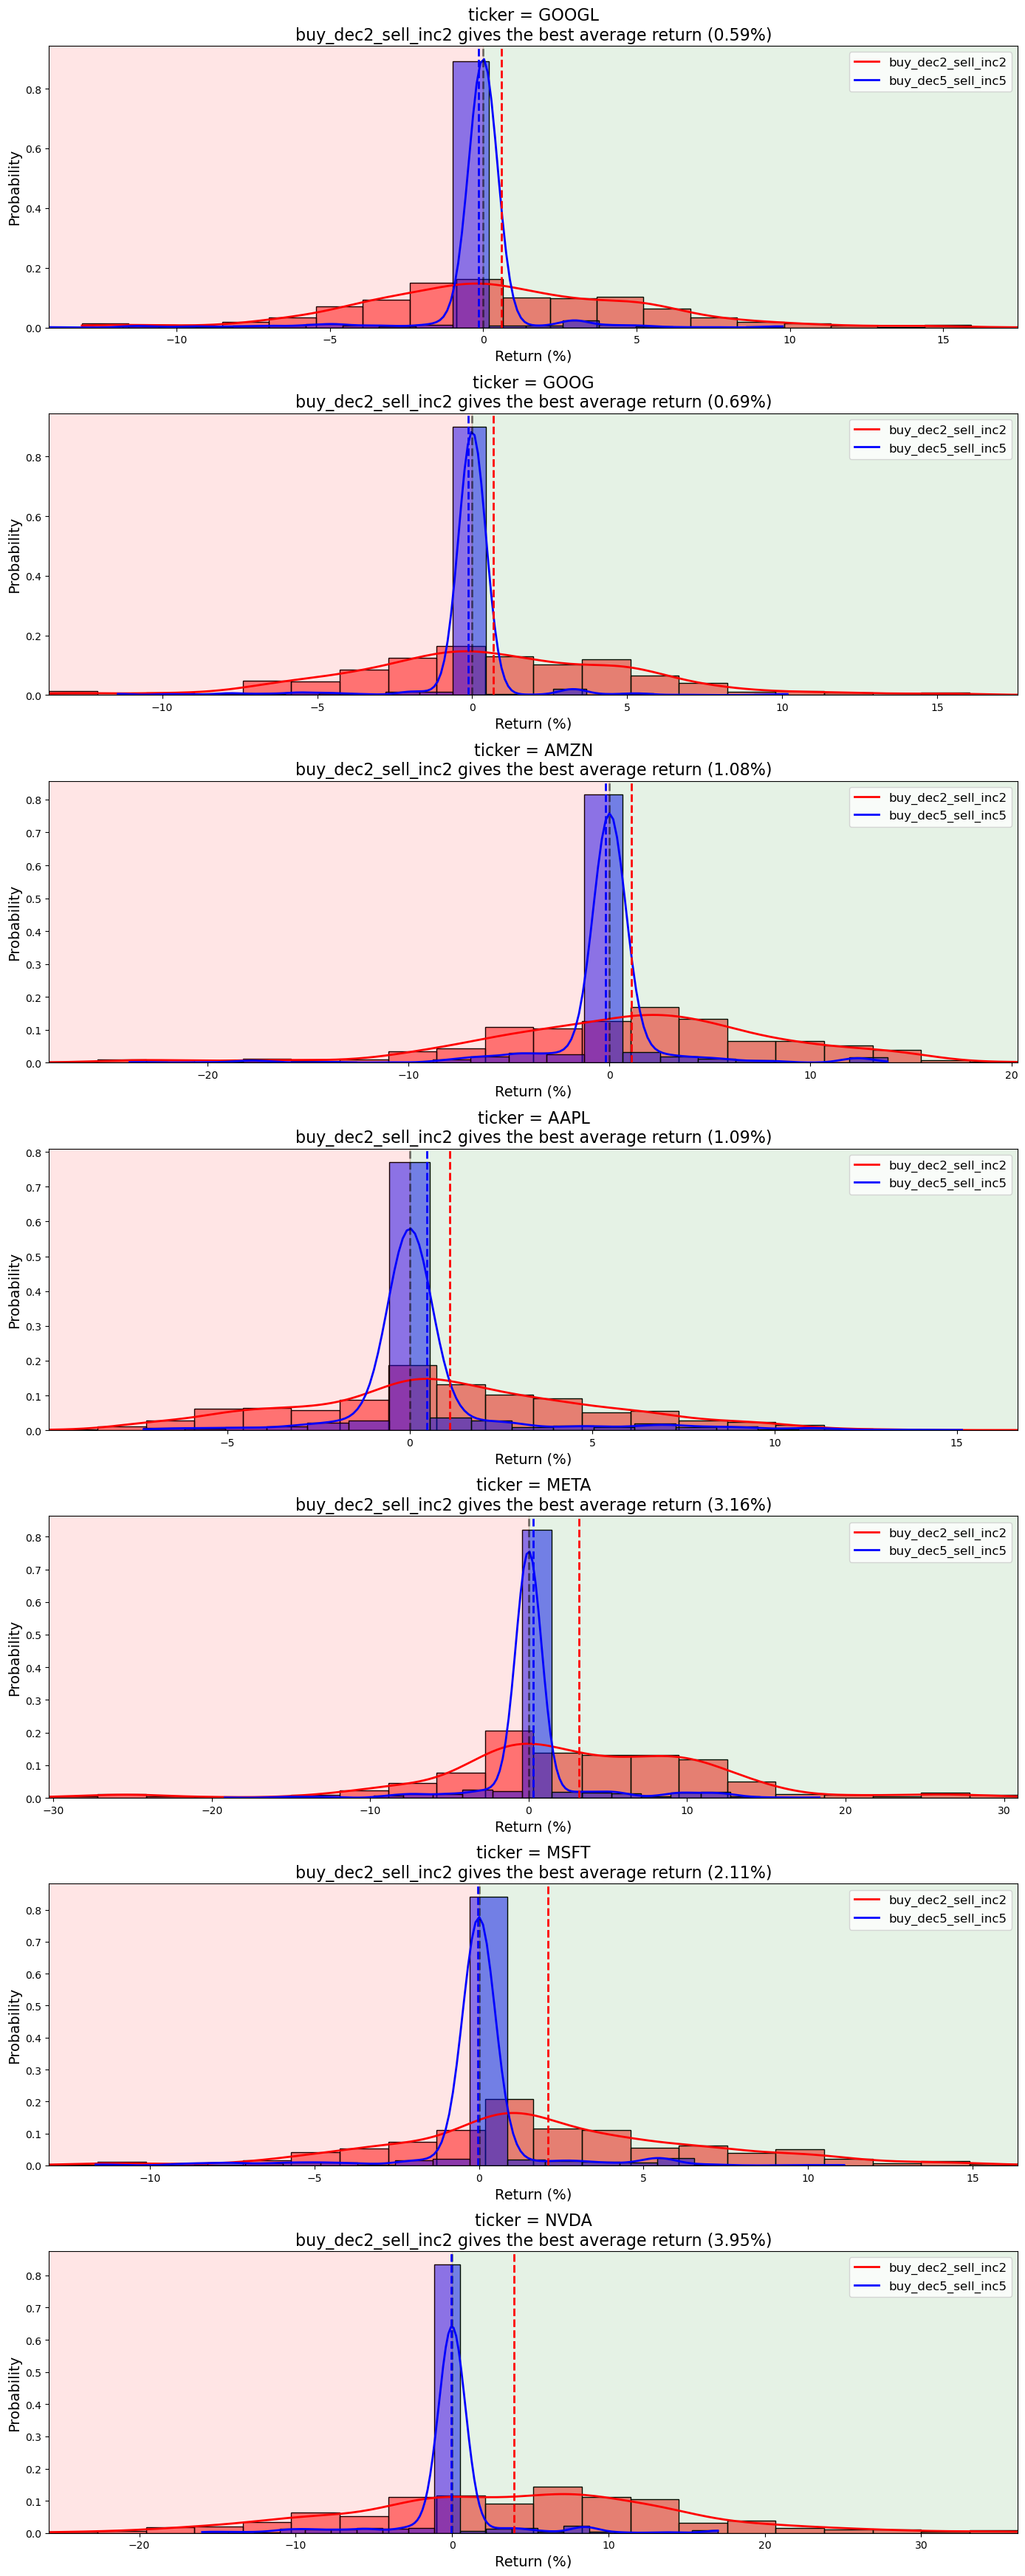

In [14]:
#Suppose we want to run strategies for 30 days.
time_range = 30
#This tells us the back tests amount
all_results,all_history= run_backtest(symbols)
plot(all_results,symbols)

- buy_dec2_sell_inc2 consistently outperforms buy_dec5_sell_inc5.
- All stocks show positive returns with buy_dec2_sell_inc2.
- buy_dec5_sell_inc5 often yields zero or negative returns.
- Opting for shorter decrease periods as buy-in triggers may be more advantageous. This approach could allow for more timely entry into upward trends while still capitalizing on minor dips.

- Top Performers:
    NVDA (3.95%), META (3.16%), MSFT (2.11%) with buy_dec2_sell_inc2.

## Further investigation into why? Take NVDA as an example and run each test for one month

- The return plots reveal that buy_dec5_sell_inc5 generate 0% or slight loss. THis might because waiting for longer periods to buy in or sell out may yield minimal returns. For consistently growing stocks, a longer-term strategy might miss buying opportunities due to the extended wait for significant decreases. Consequently, I miss chances to catch uptrends, leaving me without any stock holdings. 
-  These part is aiming to validate this reasoning.

Before dig in, lets see the trend of Nvidida from 2022 to 2024 September. we can see s prolong uptrend from 2023 to 2024 June. These accounts over 50% duration of total backtest period.

<function matplotlib.pyplot.show(close=None, block=None)>

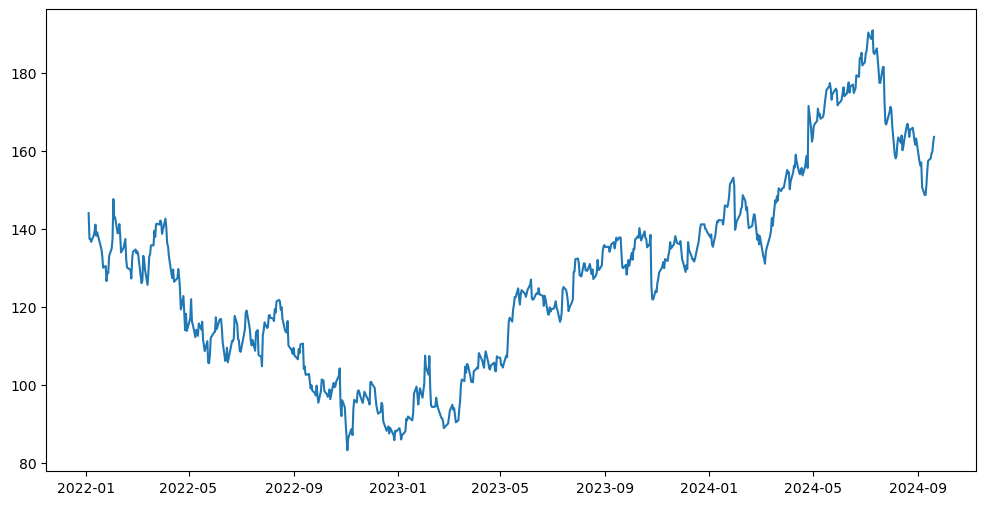

In [67]:
nvda_df = all_history[0][1]

# Retrieve 'Date' and 'Close' columns
date_close_data = nvda_df[['Date', 'Close']]
date_close_data
plt.figure(figsize=(12, 6))
plt.plot(date_close_data.Date,date_close_data.Close)
plt.show

In [61]:
# Set symbols into what we want to investigate in
symbols=['NVDA']
time_range = 30
all_results,history= run_backtest(symbols)

In [62]:
def plot_trading_strategies(all_results):
    strategies = ['buy_dec2_sell_inc2', 'buy_dec5_sell_inc5']
    colors = ['blue', 'red']
    
    plt.figure(figsize=(12, 6))
    
    for strategy, color in zip(strategies, colors):
        data = all_results['NVDA'][strategy]
        
        dates = [datetime.strptime(x[0], '%Y-%m-%d') for x in data]
        trade_counts = [x[2][1] for x in data]
        
        plt.plot(dates, trade_counts, color=color, label=strategy)
    
    plt.xlabel('Start Date')
    plt.ylabel('Trade Count')
    plt.title('NVDA Trading Strategies Comparison')
    plt.legend()
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

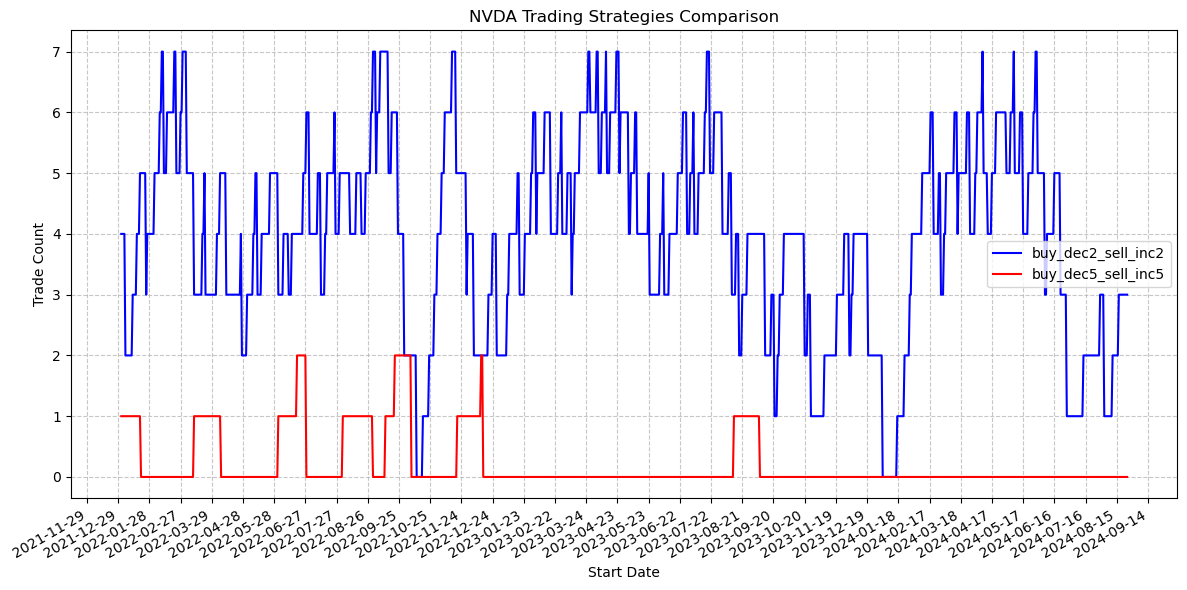

In [63]:
plot_trading_strategies(all_results)

The time series of trade counts shows that buy_dec5_sell_inc5 executed almost no trades from 2023 to September 2024, aligning with the upward trend of stock prices. However, buy_dec2_sell_inc2 maintained a higher trade frequency even after 2023. The volatility of buy_dec2_sell_inc2 indicates that it trades very frequently and can generate profits from this process.

In [76]:
def plot_trading_frequency_strategies(all_results):
    # Extract the second values (trade counts) from 'buy_dec2_sell_inc2' and 'buy_dec5_sell_inc5'
    trade_count_dec2_inc2 = [x[2][1] for x in all_results['NVDA']['buy_dec2_sell_inc2']]
    trade_count_dec5_inc5 = [x[2][1] for x in all_results['NVDA']['buy_dec5_sell_inc5']]
    
    # Combine all trade counts to define consistent bin edges based on the range of values
    all_trade_counts = trade_count_dec2_inc2 + trade_count_dec5_inc5
    min_value = min(all_trade_counts)
    max_value = max(all_trade_counts)
    
    # Set the bins with integer steps
    bins = np.arange(min_value, max_value + 1)  # Creates integer bins
    
    # Plot the histogram for each set of trade counts with different colors
    plt.figure(figsize=(12, 6))
    
    # Plot for 'buy_dec2_sell_inc2' with blue color
    plt.hist(trade_count_dec2_inc2, bins=bins, color='blue', alpha=0.5, label='buy_dec2_sell_inc2')
    
    # Plot for 'buy_dec5_sell_inc5' with orange color
    plt.hist(trade_count_dec5_inc5, bins=bins, color='orange', alpha=0.5, label='buy_dec5_sell_inc5')
    
    # Add title and labels
    plt.title('Histogram of Trade Counts for buy_dec2_sell_inc2 and buy_dec5_sell_inc5')
    plt.xlabel('Trade Count')
    plt.ylabel('Frequency')
    
    # Set x-axis to show only integer values
    plt.xticks(np.arange(min_value, max_value + 1, 1))
    
    # Add legend to distinguish the two plots
    plt.legend()
    
    # Show the plot
    plt.show()

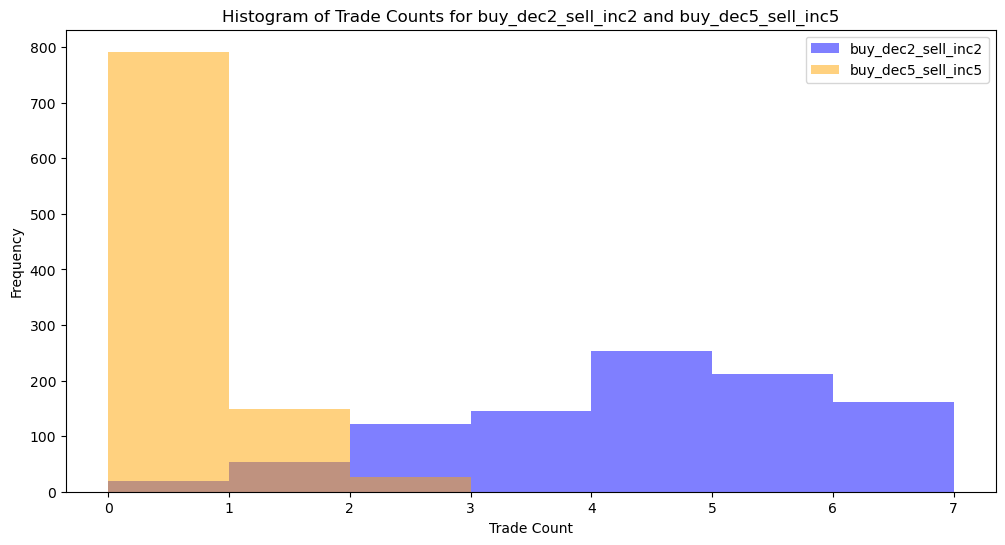

In [77]:
plot_trading_frequency_strategies(all_results)

- buy_dec5_sell_inc5 (orange) has an extremely high frequency of 0 trades. buy_dec5_sell_inc5 rarely exceeds 2 trades, indicating it's much more selective or misses opportunities. This suggests that buy_dec5_sell_inc5 often fails to execute trades, likely due to its stricter criteria.

- buy_dec2_sell_inc2 peaks at 4-5 trades, suggesting this is its optimal activity level.